In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.7 MB/s 


In [ ]:
# Importação das bibliotecas
from google.colab import drive
import pandas as pd
from pandas_profiling import ProfileReport 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Importando as bases de dados

In [ ]:
df_train = pd.read_csv('/content/gdrive/My Drive/Day 07/Datasets/train.csv')
df_stores = pd.read_csv('/content/gdrive/My Drive/Day 07/Datasets/stores.csv')
df_features = pd.read_csv('/content/gdrive/My Drive/Day 07/Datasets/features.csv')

In [ ]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


# 1. Análise e Tratamento dos Dados

### 1.1 União das tabelas

In [ ]:
df = pd.merge(pd.merge(df_train,df_features),df_stores) 

In [ ]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


### 1.2 EDA

In [ ]:
df = pd.get_dummies(df, columns=['Type']) 

In [ ]:
df.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Size              int64
Type_A            uint8
Type_B            uint8
Type_C            uint8
dtype: object

In [ ]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Size                 0
Type_A               0
Type_B               0
Type_C               0
dtype: int64

In [ ]:
df['MarkDown1'].fillna(0, inplace=True)
df['MarkDown2'].fillna(0, inplace=True)
df['MarkDown3'].fillna(0, inplace=True)
df['MarkDown4'].fillna(0, inplace=True)
df['MarkDown5'].fillna(0, inplace=True)

In [ ]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Size            0
Type_A          0
Type_B          0
Type_C          0
dtype: int64

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df['Year'] = [int(i.strftime("%Y")) for i in df['Date']]
df['Month'] = [int(i.strftime("%m")) for i in df['Date']]
df['Day'] = [int(i.strftime("%d")) for i in df['Date']] 

In [ ]:
df.drop(columns=['Date'], inplace=True)

In [ ]:
df['IsHoliday'] = df['IsHoliday'].astype(int)

In [ ]:
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_A,Type_B,Type_C,Year,Month,Day
0,1,1,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,1,0,0,2010,2,5
1,1,2,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,1,0,0,2010,2,5
2,1,3,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,1,0,0,2010,2,5
3,1,4,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,1,0,0,2010,2,5
4,1,5,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,1,0,0,2010,2,5


In [ ]:
df_novo = df.sample(n=1000)

In [ ]:
df_novo.shape

(1000, 20)

In [ ]:
# Definindo preditores e variavel target
X = df_novo.drop(columns=['Weekly_Sales'])
y = df_novo[['Weekly_Sales']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Normalização

In [ ]:
scaler = StandardScaler().fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
All_Regressors = [LinearRegression(),SGDRegressor(),HuberRegressor(),GradientBoostingRegressor(),ExtraTreesRegressor(), RandomForestRegressor()] 

In [ ]:
y_train.squeeze()

177747    20664.01
379163     2137.64
64692       897.40
40087        26.88
22365      2942.34
            ...   
199377     3313.18
62022     14237.69
389615    20136.86
154394    41615.51
112512     7124.58
Name: Weekly_Sales, Length: 67451, dtype: float64

### Modelagem

In [ ]:
l = []
for model in All_Regressors:
    Predictor = model.fit(X_train,y_train.squeeze())
    y_pred = Predictor.predict(X_test)
    print(type(model).__name__)
    l.append({type(model).__name__:[metrics.mean_squared_error(y_test.squeeze(), y_pred),metrics.mean_absolute_error(y_test.squeeze(),y_pred),metrics.r2_score(y_test.squeeze(),y_pred)]}) 


LinearRegression
SGDRegressor
HuberRegressor
GradientBoostingRegressor
ExtraTreesRegressor
RandomForestRegressor


In [ ]:
append_data =[]
for i in range(len(l)):
    append_data.append(pd.DataFrame(l[i]))
    appended_data = pd.concat(append_data, axis=1)
    appended_data.rename(index={0: 'MSE',1:'MAE',2:'R2'},inplace=True)

In [ ]:
appended_data.round(1)

,LinearRegression,SGDRegressor,HuberRegressor,GradientBoostingRegressor,ExtraTreesRegressor,RandomForestRegressor
MSE,467445726.0,477420508.9,511875323.2,216545104.2,283228346.7,222654283.9
MAE,15917.1,16024.6,14175.3,9325.0,10798.1,9975.6
R2,0.0,0.0,-0.1,0.6,0.4,0.5


In [ ]:
%matplotlib inline

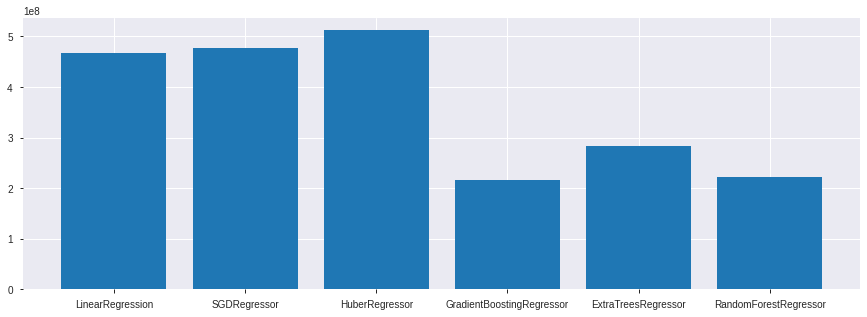

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(appended_data.columns.tolist(),appended_data.iloc[0].values.tolist())
plt.show()

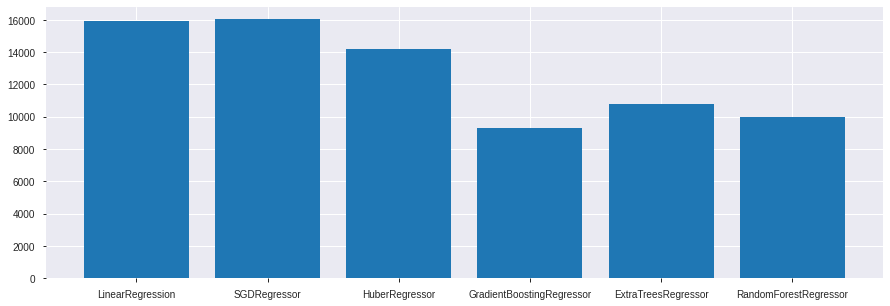

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(appended_data.columns.tolist(),appended_data.iloc[1].values.tolist())
plt.show()

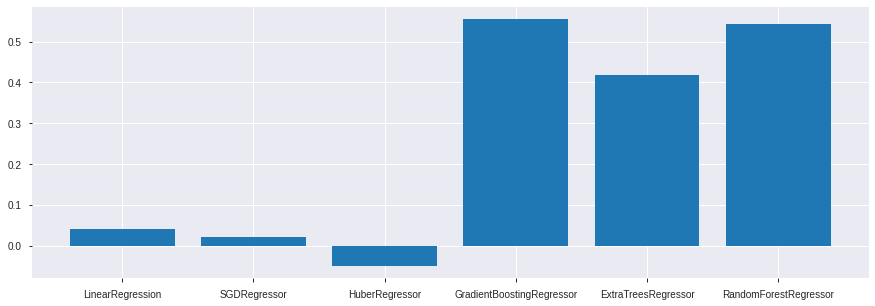

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(appended_data.columns.tolist(),appended_data.iloc[2].values.tolist())
plt.show()

In [ ]:
grid = {'n_estimators':[100,200,300],
        'criterion':["squared_error", "absolute_error"],
       'max_depth':[5,10,20,40]}

Nana = GridSearchCV(RandomForestRegressor(),param_grid=grid,cv=3,n_jobs = -1, verbose = 2).fit(X_train,y_train)
Nana1 = Nana.best_estimator_.predict(X_test) 

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
Nana.best_estimator_

RandomForestRegressor(max_depth=40, n_estimators=300)

In [ ]:
print('MSE', metrics.mean_squared_error(y_test, Nana))
print('MAE', metrics.mean_absolute_error(y_test, Nana))
print('R2', metrics.r2_score(y_test, Nana))


MSE 230109711.0764249
MAE 10175.388041499999
R2 0.5279596214631115


# Análise Macro

In [ ]:
# Definindo preditores e variavel target
X = df.drop(columns=['Weekly_Sales'])
y = df[['Weekly_Sales']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Normalização

In [ ]:
scaler = StandardScaler().fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
reg = RandomForestRegressor(max_depth=40, n_estimators=300).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [ ]:
y_pred = reg.predict(X_test)

In [ ]:
print('MSE', metrics.mean_squared_error(y_test, y_pred))
print('MAE', metrics.mean_absolute_error(y_test, y_pred))
print('R2', metrics.r2_score(y_test, y_pred))

MSE 13769230.75620102
MAE 1383.0466471846712
R2 0.9738090669823879
